<a href="https://colab.research.google.com/github/ramesh0805/Major/blob/main/Madhan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install necessary packages
!pip install optuna lightgbm imbalanced-learn shap

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,accuracy_score
import optuna
import shap
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset
train = pd.read_csv('madhan_train.csv')
print("Dataset shape:", train.shape)
print(train.head())

Dataset shape: (130019, 122)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...  

In [5]:
# Drop ID column
train = train.drop(columns=['SK_ID_CURR'])

# Handle missing values for numeric columns
numeric_cols = train.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
train[numeric_cols] = imputer.fit_transform(train[numeric_cols])

# Encode categorical variables with one-hot encoding
categorical_cols = train.select_dtypes(include='object').columns
train = pd.get_dummies(train, columns=categorical_cols)

# Check for any remaining missing values
print("Missing values after preprocessing:", train.isnull().sum().sum())
print("New dataset shape:", train.shape)

Missing values after preprocessing: 0
New dataset shape: (130019, 245)


In [6]:
# Feature engineering: Debt-to-income ratio
train['DEBT_INCOME_RATIO'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL'].replace(0, np.nan)

# Fill any new NaNs from feature engineering
train['DEBT_INCOME_RATIO'] = train['DEBT_INCOME_RATIO'].fillna(train['DEBT_INCOME_RATIO'].median())

print("Sample of engineered feature:")
print(train[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DEBT_INCOME_RATIO']].head())

Sample of engineered feature:
   AMT_CREDIT  AMT_INCOME_TOTAL  DEBT_INCOME_RATIO
0    406597.5          202500.0           2.007889
1   1293502.5          270000.0           4.790750
2    135000.0           67500.0           2.000000
3    312682.5          135000.0           2.316167
4    513000.0          121500.0           4.222222


In [7]:
# Split features and target
X = train.drop(columns=['TARGET'])
y = train['TARGET']

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Target distribution:\n", y.value_counts(normalize=True))

X shape: (130019, 245)
y shape: (130019,)
Target distribution:
 TARGET
0.0    0.918558
1.0    0.081442
Name: proportion, dtype: float64


In [8]:
# Balance dataset with ADASYN
adasyn = ADASYN(random_state=42)
X_balanced, y_balanced = adasyn.fit_resample(X, y)

print("Balanced X shape:", X_balanced.shape)
print("Balanced y shape:", y_balanced.shape)
print("New target distribution:\n", pd.Series(y_balanced).value_counts(normalize=True))

Balanced X shape: (241318, 245)
Balanced y shape: (241318,)
New target distribution:
 TARGET
1.0    0.505093
0.0    0.494907
Name: proportion, dtype: float64


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (193054, 245)
X_test shape: (48264, 245)


In [10]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'objective': 'binary',
        'random_state': 42,
        'verbose': -1  # Suppress LightGBM output
    }

    # Train LightGBM model
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    return auc

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print best parameters and score
print("Best AUC-ROC:", study.best_value)
print("Best parameters:", study.best_params)

[I 2025-03-22 19:06:52,315] A new study created in memory with name: no-name-b501dd64-91c6-4fff-a261-764c5905fdaf
[I 2025-03-22 19:07:29,986] Trial 0 finished with value: 0.9739527876430727 and parameters: {'learning_rate': 0.2669279378815764, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 55, 'subsample': 0.5771328915107665, 'colsample_bytree': 0.8153628554031744, 'n_estimators': 421}. Best is trial 0 with value: 0.9739527876430727.
[I 2025-03-22 19:08:02,855] Trial 1 finished with value: 0.9582579662449788 and parameters: {'learning_rate': 0.015012458434155137, 'num_leaves': 110, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.772599876095017, 'colsample_bytree': 0.7960595522551163, 'n_estimators': 134}. Best is trial 0 with value: 0.9739527876430727.
[I 2025-03-22 19:09:18,021] Trial 2 finished with value: 0.9729028556031563 and parameters: {'learning_rate': 0.27768200528649645, 'num_leaves': 108, 'max_depth': 14, 'min_child_samples': 55, 'subsample': 0.58212187301

Best AUC-ROC: 0.975480659041088
Best parameters: {'learning_rate': 0.07389223128615556, 'num_leaves': 83, 'max_depth': 4, 'min_child_samples': 75, 'subsample': 0.6707910419729588, 'colsample_bytree': 0.835571160874236, 'n_estimators': 997}


In [19]:
# Train final model with best parameters
best_params = study.best_params
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Predict on test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate and display metrics
final_auc = roc_auc_score(y_test, y_pred_proba)
final_accuracy = accuracy_score(y_test, y_pred)  # Added accuracy
print(f"Final AUC-ROC on test set: {final_auc:.4f}")
print(f"Final Accuracy on test set: {final_accuracy:.4f}")

Final AUC-ROC on test set: 0.9754
Final Accuracy on test set: 0.9154


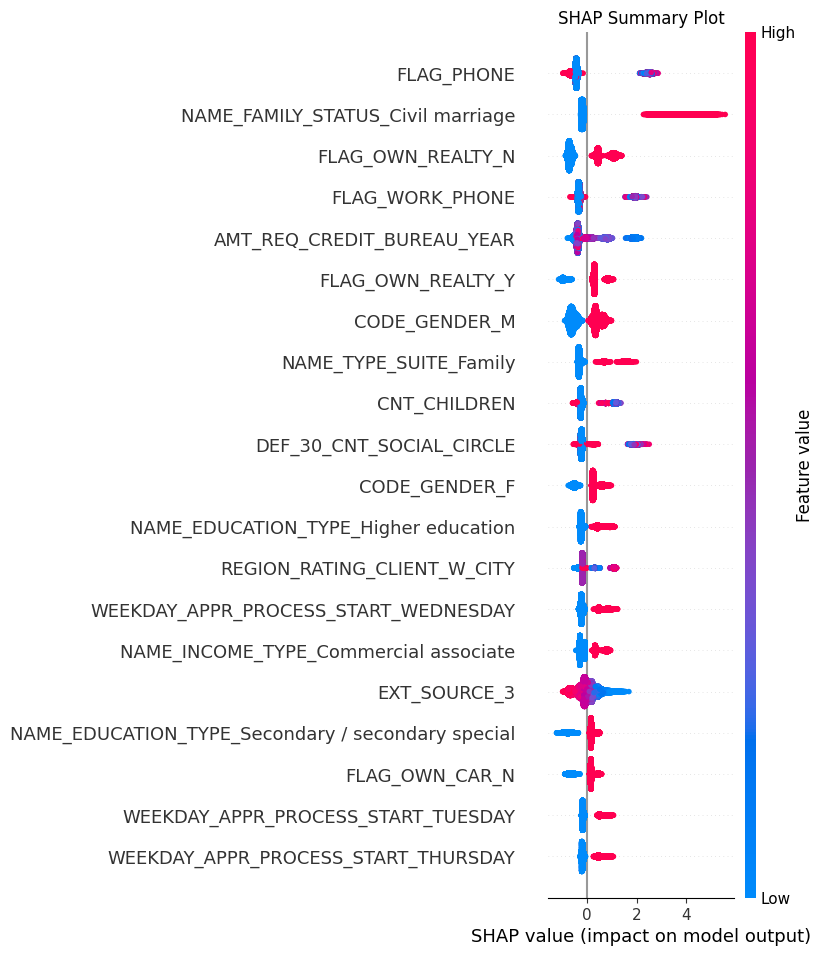

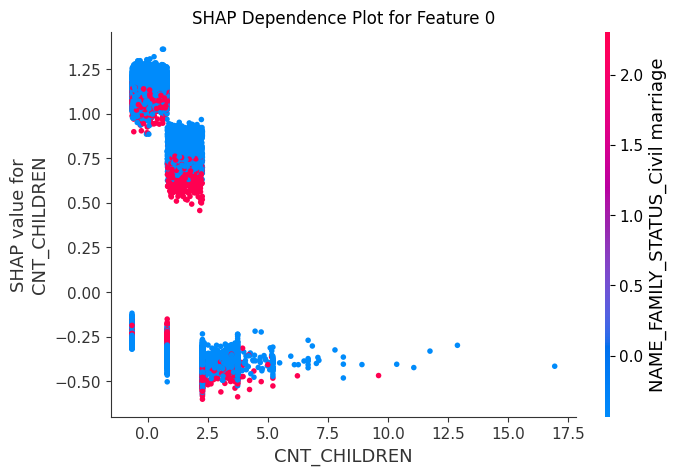

In [20]:
# Calculate SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot")
plt.show()

# Dependence plot for top feature (example: first feature)
shap.dependence_plot(0, shap_values, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Dependence Plot for Feature 0")
plt.show()

In [17]:
# Optimization history
optuna.visualization.plot_optimization_history(study)
plt.show()

# Parameter importance
optuna.visualization.plot_param_importances(study)
plt.show()